# **Loading Stock Data**

In [48]:
%pip install yfinance
%pip install scikit-learn
%pip install ta


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  1 of 1 completed
f:\Projects\SmartStockInsight\.venv\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
C:\Users\user\AppData\Local\Temp\ipykernel_2028\1923095518.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


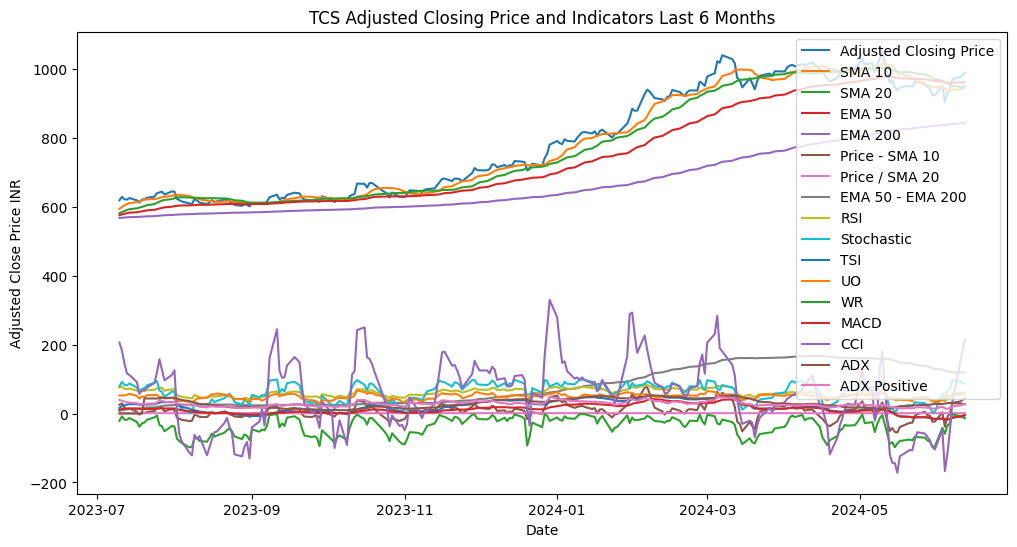

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta import add_all_ta_features
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Download TCS stock data for the last 6 months
ticker = ['TCS.NS', 'TATAMOTORS.NS', 'INFY.NS', 'ASIANPAINT.NS', 'ONGC.NS']
stock_idx = 1
data = yf.download(ticker[stock_idx], period='1y', interval='1d')



# Use the adjusted closing price

data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# preprocess
data = data.fillna(method='ffill')

# Remove outliers
data = data[(data['Close'] - data['Close'].mean()).abs() < 3 * data['Close'].std()]

# Log transform
# data['Close'] = np.log(data['Close'])

# Scale the features
# scaler = MinMaxScaler()
# data[['Close', 'Volume']] = scaler.fit_transform(data[['Close', 'Volume']])


# data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
# data = data[['Adj Close']]
# data.rename(columns={'Adj Close': 'Close'}, inplace=True)

# Calculate simple moving averages and exponential moving averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Create additional features
data['PRICE_SMA_10'] = data['Close'] - data['SMA_10']
data['PRICE_SMA_20_Ratio'] = data['Close'] / data['SMA_20']
data['EMA_DIFF'] = data['EMA_50'] - data['EMA_200']

data = data.dropna()

# Plot the adjusted closing price
# Plot the adjusted closing price and indicators
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Adjusted Closing Price')
plt.plot(data['SMA_10'], label='SMA 10')
plt.plot(data['SMA_20'], label='SMA 20')
plt.plot(data['EMA_50'], label='EMA 50')
plt.plot(data['EMA_200'], label='EMA 200')
plt.plot(data['PRICE_SMA_10'], label='Price - SMA 10')
plt.plot(data['PRICE_SMA_20_Ratio'], label='Price / SMA 20')
plt.plot(data['EMA_DIFF'], label='EMA 50 - EMA 200')
plt.plot(data['momentum_rsi'], label='RSI')
plt.plot(data['momentum_stoch'], label='Stochastic')
plt.plot(data['momentum_tsi'], label='TSI')
plt.plot(data['momentum_uo'], label='UO')
plt.plot(data['momentum_wr'], label='WR')
plt.plot(data['trend_macd'], label='MACD')
plt.plot(data['trend_cci'], label='CCI')
plt.plot(data['trend_adx'], label='ADX')
plt.plot(data['trend_adx_pos'], label='ADX Positive')

plt.title('TCS Adjusted Closing Price and Indicators Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price INR')
plt.legend()
plt.show()



In [2]:
# combine DataFrame

stock_list = ["TCS", "Tata_Motors", "Infosys", "Asian_Paints", "ONGC"]
sentiment_data = pd.read_csv(rf'../Dataset/{stock_list[stock_idx]}_sentiment_data.csv')
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
sentiment_data.set_index('Date', inplace=True)

# Combine with the adjusted closing price data
combined_df = data.join(sentiment_data, how='left')

# Fill any missing sentiment scores (if necessary) - for example, with 0 for neutrality
combined_df.fillna({'Label': 0}, inplace=True)

print(combined_df.head())
# combined_df.to_csv('combined_data.csv')



                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-10  624.000000  634.799988  617.549988  618.650024  614.830505   
2023-07-11  624.950012  630.450012  622.150024  628.500000  624.619690   
2023-07-12  629.950012  630.799988  619.349976  621.450012  617.613281   
2023-07-13  625.000000  626.500000  615.500000  620.650024  616.818237   
2023-07-14  623.000000  626.000000  619.500000  624.900024  621.041931   

              Volume    volume_adi  volume_obv  volume_cmf     volume_fi  ...  \
Date                                                                      ...   
2023-07-10  23802524 -5.437152e+06    77680701   -0.022650  7.935570e+07  ...   
2023-07-11  12051173  9.513782e+05    89731874    0.008600  8.497685e+07  ...   
2023-07-12  10785502 -5.877805e+06    78946372    0.018572  6.197478e+07  ...   
2023-07-13   9689708 -6.494380e+06    69256664   -0.023593  5.201386e+07  ..

In [3]:
combined_df.shape

(226, 100)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Select features and target variable
features = combined_df[['Close', 'Label','momentum_rsi', 'momentum_stoch', 'momentum_tsi', 'momentum_uo', 'momentum_wr', 'trend_macd', 'trend_cci', 'trend_adx', 'trend_adx_pos']]
target = combined_df['Close']

corr = combined_df.corr()["Close"].abs().sort_values(ascending=False)

# Select the top N features based on correlation
N = 19 # Number of features to select
top_n_features = corr.head(N).index.tolist()
top_n_features.insert(1, 'Label')
print(top_n_features)

# Create a new DataFrame with the selected features and the target variable
features = combined_df[top_n_features]
features = features[['Close'] + [col for col in features.columns if col != 'Close']]
target = combined_df["Close"]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60

X, y = create_dataset(scaled_features, time_step)

# Split the data into training and test sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


['Close', 'Label', 'others_cr', 'Adj Close', 'Low', 'High', 'Open', 'trend_ema_fast', 'trend_ichimoku_conv', 'SMA_10', 'volatility_kcc', 'volatility_kcl', 'volume_vwap', 'volatility_kch', 'momentum_kama', 'trend_sma_fast', 'trend_ichimoku_a', 'volatility_bbh', 'EMA_DIFF', 'volatility_dch']


In [5]:
X_train.shape[2]

20

In [54]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout

# # Build the LSTM model
# model = Sequential()

# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(25))
# model.add(Dense(1))


# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=100)

# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1))

# # Compile and train the model
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))



In [55]:
# # Testing the model using GRU

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import l2

# # Define the model architecture
# model = Sequential()
# model.add(GRU(100, return_sequences=True, input_shape=(time_step, X.shape[2])))  # Use GRU instead of LSTM
# model.add(Dropout(0.4))  # Increase dropout rate
# model.add(GRU(100, return_sequences=False))  # Use GRU instead of LSTM
# model.add(Dropout(0.4))  # Increase dropout rate
# model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))  # Increase units in Dense layer
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Increase patience

# # Train the model with early stopping
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                     epochs=300, batch_size=64, callbacks=[early_stop])  # Increase epochs

# # Evaluate the model
# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)

# print("Training Loss:", train_loss)
# print("Testing Loss:", test_loss)

In [56]:
# # Testing the model using LSTM and GRU
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import l2

# # Define the model architecture
# model = Sequential()
# model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X.shape[2])))  # LSTM layer
# model.add(Dropout(0.3))  # Dropout layer
# model.add(GRU(100, return_sequences=False))  # GRU layer
# model.add(Dropout(0.3))  # Dropout layer
# model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# # Train the model with early stopping
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                     epochs=250, batch_size=64, callbacks=[early_stop])

# # Evaluate the model
# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)

# print("Training Loss:", train_loss)
# print("Testing Loss:", test_loss)

In [69]:
X.shape[2]

20

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=200, batch_size=32)

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print("Training Loss:", train_loss)
print("Testing Loss:", test_loss)


f:\Projects\SmartStockInsight\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 518ms/step - loss: 0.0929 - val_loss: 0.0340
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0265 - val_loss: 0.0124
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0080 - val_loss: 0.0185
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0078 - val_loss: 0.0057
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0109 - val_loss: 0.0060
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0064 - val_loss: 0.0173
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.

In [16]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense,Dropout
# from tensorflow.keras.callbacks import EarlyStopping


# # Define the model
# model = Sequential()
# model.add(LSTM(288, input_shape=(time_step, X.shape[2]), return_sequences=True, activation='tanh'))
# model.add(Dropout(0.2))
# model.add(LSTM(480, return_sequences=False, activation='tanh'),)
# model.add(Dropout(0.0))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')
# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# # Fit the model
# model.fit(X_train, y_train, epochs=300, batch_size=32, 
#           validation_data=(X_test, y_test))

# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)

# print("Training Loss:", train_loss)
# print("Testing Loss:", test_loss)

f:\Projects\SmartStockInsight\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.3473 - val_loss: 0.0370
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0269 - val_loss: 0.0124
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0215 - val_loss: 0.0073
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0096 - val_loss: 0.0193
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0053 - val_loss: 0.0076
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0062 - val_loss: 0.0190
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0040 - val_loss: 0.0062
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0036 - val_loss: 0.0048
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0028 - val_loss: 0.0153
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0036 - val_loss: 0.0066
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0032 - val_loss: 0.0070
Epoch 12/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0028 - val_loss: 0.0099
Epoch 13/

In [7]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = keras.Sequential()
#     model.add(layers.LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
#                           input_shape=(time_step, X.shape[2]),
#                           return_sequences=True,
#                           activation='tanh'))
#     model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(layers.LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
#                           return_sequences=False,
#                           activation='tanh'))
#     model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(layers.Dense(16, activation='relu'))
#     model.add(layers.Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=5,  # how many model configurations would you like to test?
#     executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
#     directory='my_dir',
#     project_name='helloworld')

# tuner.search_space_summary()

# # Assume X_train, y_train, X_val, y_val are your data
# tuner.search(X_train, y_train,
#              epochs=5,
#              validation_data=(X_test, y_test))

# tuner.results_summary()

Trial 5 Complete [00h 02m 46s]
val_loss: 0.006844738187889258

Best val_loss So Far: 0.005936707369983196
Total elapsed time: 00h 11m 12s
Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units_1: 288
dropout_1: 0.2
units_2: 480
dropout_2: 0.0
Score: 0.005936707369983196

Trial 0 summary
Hyperparameters:
units_1: 224
dropout_1: 0.1
units_2: 256
dropout_2: 0.2
Score: 0.006118158499399821

Trial 3 summary
Hyperparameters:
units_1: 160
dropout_1: 0.30000000000000004
units_2: 352
dropout_2: 0.30000000000000004
Score: 0.006455586447070043

Trial 4 summary
Hyperparameters:
units_1: 512
dropout_1: 0.30000000000000004
units_2: 192
dropout_2: 0.1
Score: 0.006844738187889258

Trial 1 summary
Hyperparameters:
units_1: 480
dropout_1: 0.4
units_2: 192
dropout_2: 0.0
Score: 0.008601875510066748


In [8]:
print(tuner.results_summary())

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units_1: 288
dropout_1: 0.2
units_2: 480
dropout_2: 0.0
Score: 0.005936707369983196

Trial 0 summary
Hyperparameters:
units_1: 224
dropout_1: 0.1
units_2: 256
dropout_2: 0.2
Score: 0.006118158499399821

Trial 3 summary
Hyperparameters:
units_1: 160
dropout_1: 0.30000000000000004
units_2: 352
dropout_2: 0.30000000000000004
Score: 0.006455586447070043

Trial 4 summary
Hyperparameters:
units_1: 512
dropout_1: 0.30000000000000004
units_2: 192
dropout_2: 0.1
Score: 0.006844738187889258

Trial 1 summary
Hyperparameters:
units_1: 480
dropout_1: 0.4
units_2: 192
dropout_2: 0.0
Score: 0.008601875510066748
None


In [17]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 288)        │       355,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 288)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 480)            │     1,476,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         7,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,520,485 (21.06 MB)

 Trainable params: 1,840,161 (7.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,680,324 (14.04 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 600ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


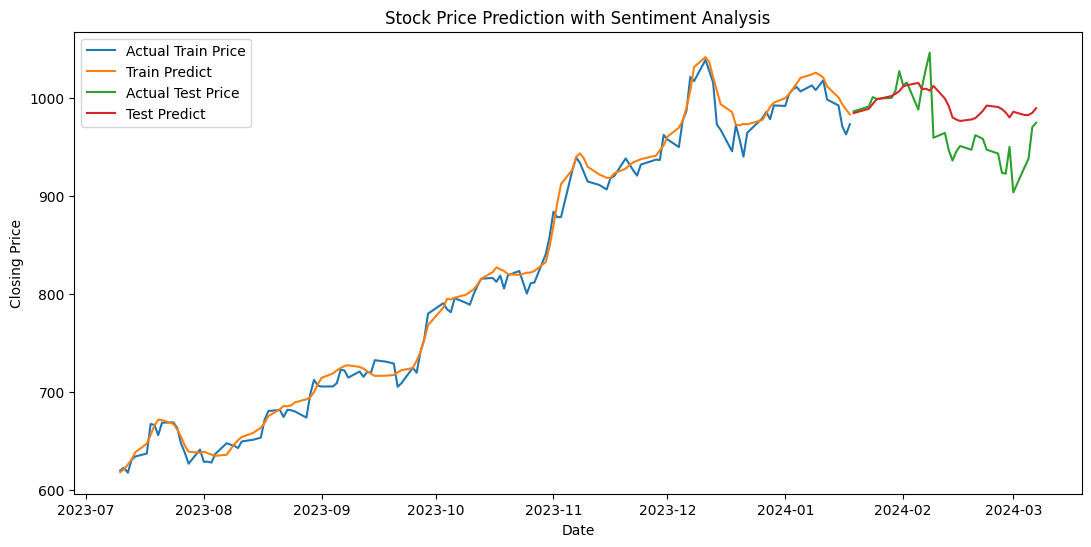

Train MAE: 8.827485040598248
Train MSE: 134.39827540578716
Train RMSE: 11.59302701652106
Train R2: 0.9927872828732366
Test MAE: 28.060143461802166
Test MSE: 1239.3331512794207
Test RMSE: 35.204163834402046
Test R2: -0.014943353602802523


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Make predictions on the training and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reshape the predictions to fit the scaler's expectations
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# Invert scaling to get actual values
train_predict_inverse = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2]-1))), axis=1))[:, 0]
test_predict_inverse = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2]-1))), axis=1))[:, 0]

# Invert scaling for actual values as well
y_train_inverse = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X_train.shape[2]-1))), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2]-1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(13, 6))
plt.plot(combined_df.index[:len(y_train_inverse)], y_train_inverse, label='Actual Train Price')
plt.plot(combined_df.index[:len(train_predict_inverse)], train_predict_inverse, label='Train Predict')
plt.plot(combined_df.index[len(y_train_inverse):len(y_train_inverse) + len(y_test_inverse)], y_test_inverse, label='Actual Test Price')
plt.plot(combined_df.index[len(y_train_inverse):len(y_train_inverse) + len(test_predict_inverse)], test_predict_inverse, label='Test Predict')
plt.title('Stock Price Prediction with Sentiment Analysis')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train_inverse, train_predict_inverse)
train_mse = mean_squared_error(y_train_inverse, train_predict_inverse)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inverse, train_predict_inverse)

test_mae = mean_absolute_error(y_test_inverse, test_predict_inverse)
test_mse = mean_squared_error(y_test_inverse, test_predict_inverse)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f'Train MAE: {train_mae}')
print(f'Train MSE: {train_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Train R2: {train_r2}')

print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Training Metrics:
MAE: 8.827485040598248
MSE: 134.39827540578716
RMSE: 11.59302701652106
R²: 0.9927872828732366

Testing Metrics:
MAE: 28.060143461802166
MSE: 1239.3331512794207
RMSE: 35.204163834402046
R²: -0.014943353602802523


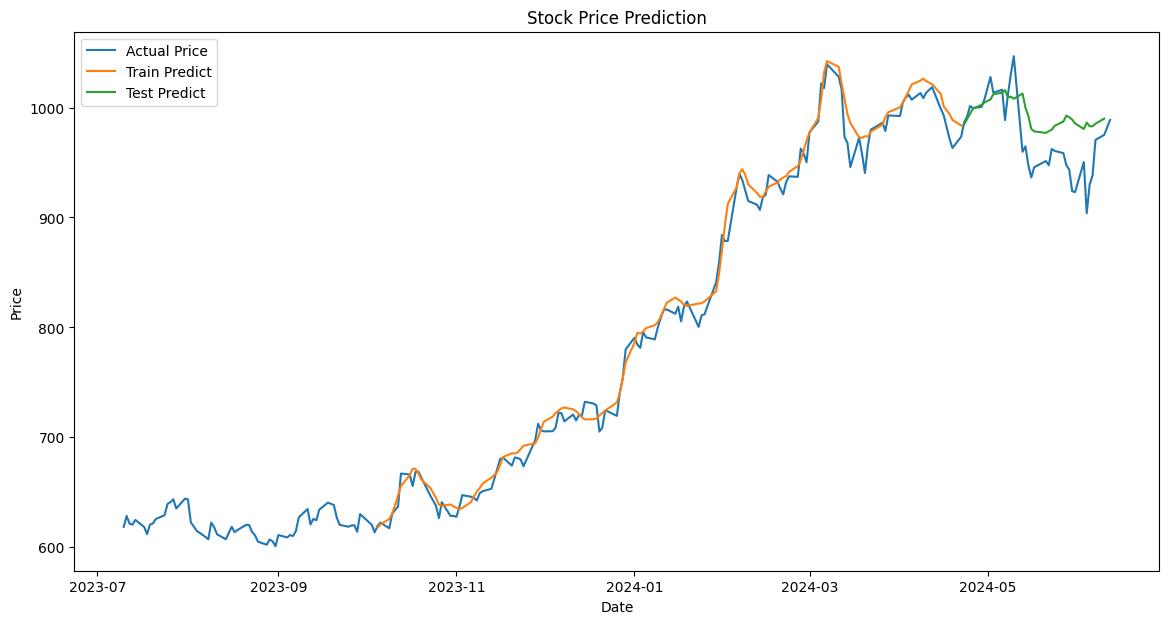

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming your data and model are already defined and trained

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Calculate metrics for training set
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_actual, train_predict)

# Calculate metrics for testing set
if len(y_test_actual) > 1:
    test_mae = mean_absolute_error(y_test_actual, test_predict)
    test_mse = mean_squared_error(y_test_actual, test_predict)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_actual, test_predict)
else:
    test_mae = test_mse = test_rmse = test_r2 = np.nan

print(f'Training Metrics:')
print(f'MAE: {train_mae}')
print(f'MSE: {train_mse}')
print(f'RMSE: {train_rmse}')
print(f'R²: {train_r2}')

print(f'\nTesting Metrics:')
print(f'MAE: {test_mae}')
print(f'MSE: {test_mse}')
print(f'RMSE: {test_rmse}')
print(f'R²: {test_r2}')

# Ensure the indices for plotting match the lengths of the predictions
train_plot_indices = combined_df.index[time_step:time_step + len(train_predict)]
test_plot_indices = combined_df.index[time_step + len(train_predict):time_step + len(train_predict) + len(test_predict)]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Price')
plt.plot(train_plot_indices, train_predict, label='Train Predict')
plt.plot(test_plot_indices, test_predict, label='Test Predict')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [21]:
# Predicting the next 30 days
last_days = scaled_features[-time_step:]

num_features = X.shape[2]
predictions = []

current_input = last_days.reshape(1, time_step, num_features)

for i in range(30):
    next_prediction = model.predict(current_input)
    predictions.append(next_prediction[0, 0])
    print(f"step {i+ 1}")

    next_prediction = next_prediction.reshape(1, 1, 1)
    next_prediction_tiled = np.tile(next_prediction, (1, 1, num_features))

    new_input = np.concatenate((current_input[:, 1:, :], next_prediction_tiled), axis=1)
    current_input = new_input

# Invert predictions to get actual values
predictions = np.array(predictions).reshape(-1, 1)
predictions_full = np.concatenate([predictions, np.zeros((predictions.shape[0], num_features - 1))], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
step 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
step 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
step 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
step 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
step 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
step 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
step 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
step 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
step 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
step 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
step 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
step 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
step 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
step 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
step 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
step 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
step 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
step 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
step 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
step 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
step 21
1/1 ━━━━━━━━━━━━━━━━━━

974.0545143048148


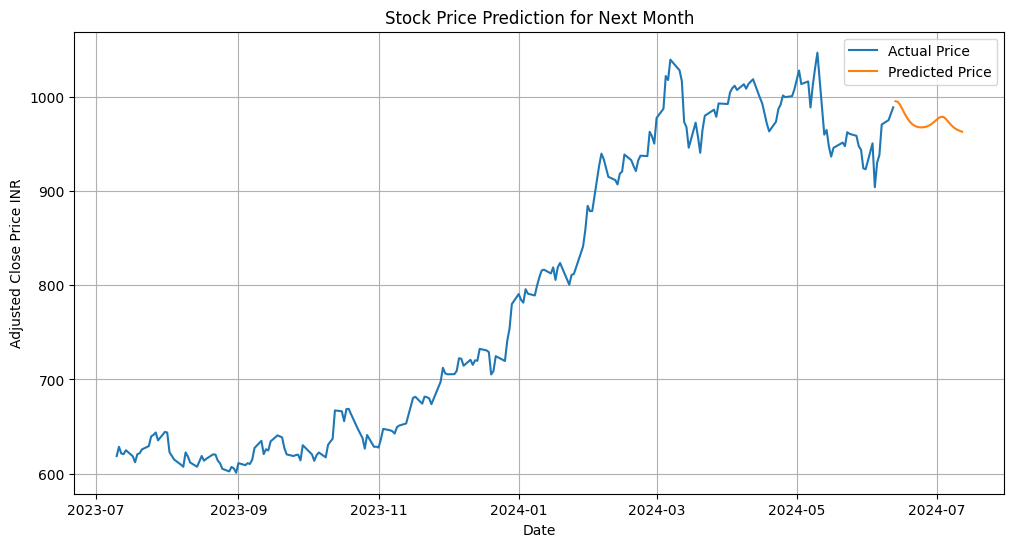

In [22]:
print(predictions.mean())

# Plot the predictions
future_dates = pd.date_range(start=combined_df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Price')
plt.plot(future_dates, predictions, label='Predicted Price')
plt.title('Stock Price Prediction for Next Month')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price INR')
plt.legend()
plt.grid()
plt.show()

In [23]:
predictions
df_temp = pd.DataFrame(predictions, columns=['Close'])
df_temp

# average of predictions
print(df_temp['Close'].mean())
print(predictions.mean())

print(predictions)




974.0545143048148
974.0545143048148
[995.17522722 994.53862288 991.30858501 986.7713912  981.98206318
 977.69166444 974.15612768 971.46568677 969.58740381 968.38028341
 967.69900042 967.4210206  967.49813244 967.91017477 968.70737787
 969.93989232 971.62062765 973.63775442 975.81784404 977.69341759
 978.73842515 978.28074791 976.19102498 973.35706519 970.50440519
 968.07438607 966.19963597 964.77366457 963.68310178 962.8306746 ]
